# Preamble

In [24]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.animation as animation
from IPython.display import HTML
# import imageio_ffmpeg
import pandas as pd
import seaborn as sns
from discretization import create_discretization_element, create_discretization_mesh
from mesh import create_2d_circle, create_2d_square, create_2d_square_structured
from scipy.integrate import solve_ivp
from solver import get_n_element_operators, AdvectionIVPSolver2D

from utils import u_exact_hill, u_exact_hill_dt, f_rhs_hill, advection_velocity_field, get_boundary_normal

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
sns.set_theme(style="whitegrid", context="paper")

# Solver

In [26]:
# Solver parameters
N = 5  # Number of nodes per element
DOMAIN_RADIUS = 1.0
DOMAIN_ORIGIN = (0.0, 0.0)
MESH_SIZE = 100  # Target mesh size

# Problem parameters
X_0, Y_0 = -0.2, -0.0
SIGMA = 0.1

t_start = 0.0
t_final = 5.0

Total DOFs: 1521


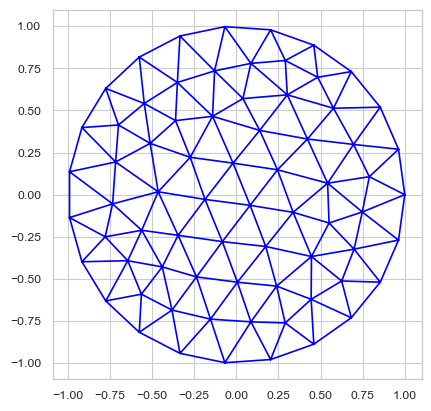

In [27]:
mesh_circle = create_2d_circle(radius=DOMAIN_RADIUS, origin=DOMAIN_ORIGIN, mesh_size=MESH_SIZE)
d_ele = create_discretization_element(N)
d_mesh = create_discretization_mesh(mesh_circle, d_ele)
print(f"Total DOFs: {d_mesh.gidx}")

mesh_circle.plot()

In [28]:
solver = AdvectionIVPSolver2D(
    mesh=mesh_circle,
    discretization_element=d_ele,
    discretization_mesh=d_mesh,
    advection_velocity_field=advection_velocity_field,
    g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
    f_rhs=f_rhs_hill,
    with_upwind_scheme=True,
)

Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 5319.66it/s]


In [29]:
# Set up initial condition
u0 = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0)

t_span = (t_start, t_final, )
n_frames = 300
t_eval = np.linspace(t_start, t_final, n_frames)

sol = solve_ivp(
    fun=solver.get_rhs_IVP,
    t_span=t_span,
    y0=u0,
    t_eval=t_eval,
    method="RK45",  # Explicit Runge-Kutta order 5(4)
    rtol=1e-8,  # Relative tolerance
    atol=1e-11,  # Absolute tolerance
    # max_step=0.0001,  # Limit max step size for accuracy
)

u_sols, t_sols = sol.y.T, sol.t
print(sol.nfev)

final_sol = sol.y.T[-1]
exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
error = final_sol - exact_sol
L2_err = np.sqrt(error @ (solver.M_global @ error))
Linf_err = np.max(np.abs(error))

print(f"L2 error: {L2_err:.6e}")
print(f"Linf error: {Linf_err:.6e}")

18644
L2 error: 1.173637e-02
Linf error: 1.154643e-01


X_0 = 0.5, SIGMA=0.05: 2.68e-2
X_0 = 0.5, SIGMA=0.10: 9.56e-3

# Results

In [10]:
# Compute Error
print("Computing Error...")
final_sol = u_sols[-1]
exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
error = final_sol - exact_sol
L2_err = np.sqrt(error @ (solver.M_global @ error))
print(f"L2 Error at t={t_final}: {L2_err:.2e}")

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Triangulation for plotting
triang = mpl.tri.Triangulation(d_mesh.x_global, d_mesh.y_global)

# Solution
tc1 = axs[0].tricontourf(triang, final_sol, levels=20, cmap="viridis")
fig.colorbar(tc1, ax=axs[0])
axs[0].set_title(f"Numerical Solution t={t_final}")
axs[0].set_aspect("equal")

# Exact
tc2 = axs[1].tricontourf(triang, exact_sol, levels=20, cmap="viridis")
fig.colorbar(tc2, ax=axs[1])
axs[1].set_title(f"Exact Solution t={t_final}")
axs[1].set_aspect("equal")

# Error
tc3 = axs[2].tricontourf(triang, error, levels=20, cmap="inferno")
fig.colorbar(tc3, ax=axs[2])
axs[2].set_title(f"Error (L2={L2_err:.2e})")
axs[2].set_aspect("equal")

plt.tight_layout()
# plt.savefig("solution_plot.png")
# print("Plot saved.")

Computing Error...


ValueError: operands could not be broadcast together with shapes (1521,) (2176,) 

<Axes: xlabel='time', ylabel='energy'>

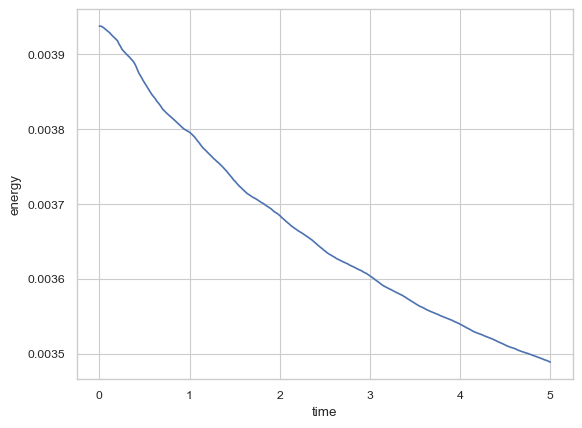

In [8]:
data = []
# Compute energy over time
for u, t in zip(u_sols, t_sols):
    energy = 0.5 * (u @ (solver.M_global @ u))
    data.append({
        "energy": energy,
        "time": t
    })
df = pd.DataFrame(data)

# Plot energy
plt.figure()
sns.lineplot(data=df, x="time", y="energy")

# Convergence

In [9]:
import itertools
import time


Ns = np.arange(1, 7)
mesh_sizes = np.linspace(0.15, 0.29, 4)

convergence_data = []
for N, mesh_size in tqdm(itertools.product(Ns, mesh_sizes)):
    print(f"Running simulation for N={N}, mesh_size={mesh_size}...")
    mesh = create_2d_circle(radius=1.0, origin=(0.0, 0.0), mesh_size=mesh_size)
    d_ele = create_discretization_element(N)
    d_mesh = create_discretization_mesh(mesh, d_ele)

    solver = AdvectionIVPSolver2D(
        mesh=mesh,
        discretization_element=d_ele,
        discretization_mesh=d_mesh,
        advection_velocity_field=advection_velocity_field,
        g_bc=lambda x, y, t: u_exact_hill(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
        g_bc_dt=lambda x, y, t: u_exact_hill_dt(x, y, t, sigma=SIGMA, x_0=X_0, y_0=Y_0),
        f_rhs=f_rhs_hill,
    )

    u0 = u_exact_hill(
        d_mesh.x_global, d_mesh.y_global, t=t_start, sigma=SIGMA, x_0=X_0, y_0=Y_0
    )

    t_span = (t_start, t_final)
    t_eval = [t_final]

    t_cpu_start = time.perf_counter()
    sol = solve_ivp(
        fun=solver.get_rhs_IVP,
        t_span=t_span,
        y0=u0,
        t_eval=t_eval,
        method="RK45",
    )
    t_cpu_total = time.perf_counter() - t_cpu_start

    if not sol.success:
        raise ValueError("Solver failed!")

    final_sol = sol.y.T[-1]
    exact_sol = u_exact_hill(d_mesh.x_global, d_mesh.y_global, t=t_final, sigma=SIGMA, x_0=X_0, y_0=Y_0)
    error = final_sol - exact_sol
    L2_err = np.sqrt(error @ (solver.M_global @ error))
    Linf_err = np.max(np.abs(error))

    convergence_data.append({
        "N": N,
        "mesh_size": mesh_size,
        "K": mesh.num_elements,
        "L2_error": L2_err,
        "Linf_error": Linf_err,
        "num_elements": mesh.num_elements,
        "sol": final_sol,
        "exact_sol": exact_sol,
        "nfev": sol.nfev,
        "time_total": t_cpu_total,
    })


0it [00:00, ?it/s]

Running simulation for N=1, mesh_size=0.15...
Assembling global matrices...


100%|██████████| 346/346 [00:00<00:00, 11051.76it/s]
1it [00:01,  1.04s/it]

Running simulation for N=1, mesh_size=0.19666666666666666...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 9065.71it/s]
2it [00:01,  1.12it/s]

Running simulation for N=1, mesh_size=0.24333333333333332...
Assembling global matrices...


100%|██████████| 142/142 [00:00<00:00, 4593.98it/s]
3it [00:02,  1.48it/s]

Running simulation for N=1, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 4204.94it/s]
4it [00:02,  1.57it/s]

Running simulation for N=2, mesh_size=0.15...
Assembling global matrices...


100%|██████████| 346/346 [00:00<00:00, 7156.46it/s]
5it [00:05,  1.31s/it]

Running simulation for N=2, mesh_size=0.19666666666666666...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 12474.29it/s]
6it [00:06,  1.40s/it]

Running simulation for N=2, mesh_size=0.24333333333333332...
Assembling global matrices...


100%|██████████| 142/142 [00:00<00:00, 11351.30it/s]
7it [00:07,  1.29s/it]

Running simulation for N=2, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 3850.67it/s]
8it [00:08,  1.15s/it]

Running simulation for N=3, mesh_size=0.15...
Assembling global matrices...


100%|██████████| 346/346 [00:00<00:00, 2071.15it/s]
9it [00:14,  2.72s/it]

Running simulation for N=3, mesh_size=0.19666666666666666...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 11399.46it/s]
10it [00:18,  2.86s/it]

Running simulation for N=3, mesh_size=0.24333333333333332...
Assembling global matrices...


100%|██████████| 142/142 [00:00<00:00, 5224.71it/s]
11it [00:20,  2.61s/it]

Running simulation for N=3, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 10643.13it/s]
12it [00:22,  2.36s/it]

Running simulation for N=4, mesh_size=0.15...
Assembling global matrices...


100%|██████████| 346/346 [00:00<00:00, 6870.57it/s]
13it [00:34,  5.31s/it]

Running simulation for N=4, mesh_size=0.19666666666666666...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 4904.86it/s]
14it [00:40,  5.51s/it]

Running simulation for N=4, mesh_size=0.24333333333333332...
Assembling global matrices...


100%|██████████| 142/142 [00:00<00:00, 10844.11it/s]
15it [00:43,  4.99s/it]

Running simulation for N=4, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 1053.29it/s]
16it [00:47,  4.45s/it]

Running simulation for N=5, mesh_size=0.15...
Assembling global matrices...


100%|██████████| 346/346 [00:00<00:00, 4498.67it/s]
17it [01:18, 12.59s/it]

Running simulation for N=5, mesh_size=0.19666666666666666...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 5501.92it/s]
18it [01:29, 12.05s/it]

Running simulation for N=5, mesh_size=0.24333333333333332...
Assembling global matrices...


100%|██████████| 142/142 [00:00<00:00, 3852.59it/s]
19it [01:35, 10.39s/it]

Running simulation for N=5, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 6319.90it/s]
20it [01:41,  8.88s/it]

Running simulation for N=6, mesh_size=0.15...
Assembling global matrices...


100%|██████████| 346/346 [00:00<00:00, 2579.92it/s]
21it [02:46, 25.93s/it]

Running simulation for N=6, mesh_size=0.19666666666666666...
Assembling global matrices...


100%|██████████| 212/212 [00:00<00:00, 3411.60it/s]
22it [03:22, 28.97s/it]

Running simulation for N=6, mesh_size=0.24333333333333332...
Assembling global matrices...


100%|██████████| 142/142 [00:00<00:00, 2218.69it/s]
23it [03:37, 24.56s/it]

Running simulation for N=6, mesh_size=0.29...
Assembling global matrices...


100%|██████████| 117/117 [00:00<00:00, 2436.16it/s]
24it [03:47,  9.49s/it]
